In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_DO_BN(conv_num=1):
    init_channel = 128
    
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=init_channel, strides=1, 
                      padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=int(init_channel/(2**int((i+1)/3))), 
                          strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_DO_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 128)        512       
_________________________________________________________________
activation (Activation)      (None, 16000, 128)        0         
_________________________________________________________________
flatten (Flatten)            (None, 2048000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 2048000)           0         
_________________________________________________________________
dense (Dense)        

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1_10 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_10 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
batch_normalization_v1_11 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_11 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 5333, 128)         0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1_28 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_28 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
batch_normalization_v1_29 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_29 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 5333, 128)         0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0458 - acc: 0.3794
Epoch 00001: val_loss improved from inf to 1.50821, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_DO_BN_4_conv_checkpoint/001-1.5082.hdf5
36805/36805 [==============================] - 181s 5ms/sample - loss: 2.0458 - acc: 0.3794 - val_loss: 1.5082 - val_acc: 0.5306
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3492 - acc: 0.5758
Epoch 00002: val_loss improved from 1.50821 to 1.12909, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_DO_BN_4_conv_checkpoint/002-1.1291.hdf5
36805/36805 [==============================] - 177s 5ms/sample - loss: 1.3495 - acc: 0.5758 - val_loss: 1.1291 - val_acc: 0.6671
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1416 - acc: 0.6451
Epoch 00003: val_loss improved from 1.12909 to 1.04662, s

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2102 - acc: 0.9315
Epoch 00027: val_loss did not improve from 0.85214
36805/36805 [==============================] - 177s 5ms/sample - loss: 0.2102 - acc: 0.9316 - val_loss: 0.9263 - val_acc: 0.7717
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2058 - acc: 0.9324
Epoch 00028: val_loss did not improve from 0.85214
36805/36805 [==============================] - 177s 5ms/sample - loss: 0.2058 - acc: 0.9324 - val_loss: 1.0032 - val_acc: 0.7615
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2000 - acc: 0.9349
Epoch 00029: val_loss did not improve from 0.85214
36805/36805 [==============================] - 177s 5ms/sample - loss: 0.2001 - acc: 0.9349 - val_loss: 0.9478 - val_acc: 0.7729
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1932 - acc: 0.9369
Epoch 00030: val_loss did not improve from 0.85214
36805/36805 [========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1019 - acc: 0.9674
Epoch 00057: val_loss did not improve from 0.85214
36805/36805 [==============================] - 177s 5ms/sample - loss: 0.1019 - acc: 0.9675 - val_loss: 1.0744 - val_acc: 0.7766
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0967 - acc: 0.9701
Epoch 00058: val_loss did not improve from 0.85214
36805/36805 [==============================] - 177s 5ms/sample - loss: 0.0967 - acc: 0.9701 - val_loss: 1.0334 - val_acc: 0.7897
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0973 - acc: 0.9694
Epoch 00059: val_loss did not improve from 0.85214
36805/36805 [==============================] - 177s 5ms/sample - loss: 0.0973 - acc: 0.9694 - val_loss: 1.1214 - val_acc: 0.7692
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0943 - acc: 0.9712
Epoch 00060: val_loss did not improve from 0.85214
36805/36805 [========

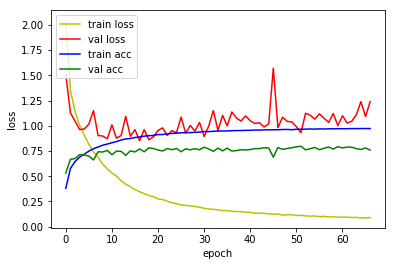

4815/4815 [==============================] - 8s 2ms/sample - loss: 0.9989 - acc: 0.7242
Loss: 0.9988764359324644 Accuracy: 0.72419524

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1012 - acc: 0.3551
Epoch 00001: val_loss improved from inf to 1.50765, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_DO_BN_5_conv_checkpoint/001-1.5076.hdf5
36805/36805 [==============================] - 182s 5ms/sample - loss: 2.1013 - acc: 0.3551 - val_loss: 1.5076 - val_acc: 0.5201
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3343 - acc: 0.5761
Epoch 00002: val_loss improved from 1.50765 to 0.99844, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_DO_BN_5_conv_checkpoint/002-0.9984.hdf5
36805/36805 [==============================] - 178s 5ms/sample - loss: 1.3346 - acc: 0.5761 - val_loss: 0.9984 - val_acc: 0.6979
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s

36800/36805 [============================>.] - ETA: 0s - loss: 0.3649 - acc: 0.8877
Epoch 00026: val_loss did not improve from 0.58542
36805/36805 [==============================] - 177s 5ms/sample - loss: 0.3650 - acc: 0.8876 - val_loss: 0.6736 - val_acc: 0.8157
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3557 - acc: 0.8893
Epoch 00027: val_loss did not improve from 0.58542
36805/36805 [==============================] - 177s 5ms/sample - loss: 0.3558 - acc: 0.8892 - val_loss: 0.6782 - val_acc: 0.8134
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3420 - acc: 0.8948
Epoch 00028: val_loss did not improve from 0.58542
36805/36805 [==============================] - 177s 5ms/sample - loss: 0.3420 - acc: 0.8949 - val_loss: 0.5957 - val_acc: 0.8369
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3274 - acc: 0.8983
Epoch 00029: val_loss did not improve from 0.58542
36805/36805 [=====================

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1797 - acc: 0.9433
Epoch 00056: val_loss did not improve from 0.58542
36805/36805 [==============================] - 177s 5ms/sample - loss: 0.1796 - acc: 0.9433 - val_loss: 0.7361 - val_acc: 0.8106
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1752 - acc: 0.9442
Epoch 00057: val_loss did not improve from 0.58542
36805/36805 [==============================] - 177s 5ms/sample - loss: 0.1753 - acc: 0.9442 - val_loss: 0.6127 - val_acc: 0.8442
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1712 - acc: 0.9458
Epoch 00058: val_loss did not improve from 0.58542
36805/36805 [==============================] - 177s 5ms/sample - loss: 0.1712 - acc: 0.9458 - val_loss: 0.7041 - val_acc: 0.8281
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1716 - acc: 0.9452
Epoch 00059: val_loss did not improve from 0.58542
36805/36805 [========

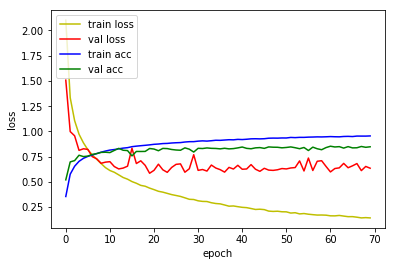

4815/4815 [==============================] - 8s 2ms/sample - loss: 0.6696 - acc: 0.8010
Loss: 0.6695837328367145 Accuracy: 0.80103844

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3584 - acc: 0.2899
Epoch 00001: val_loss improved from inf to 1.60045, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_DO_BN_6_conv_checkpoint/001-1.6004.hdf5
36805/36805 [==============================] - 185s 5ms/sample - loss: 2.3582 - acc: 0.2900 - val_loss: 1.6004 - val_acc: 0.4822
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4838 - acc: 0.5242
Epoch 00002: val_loss improved from 1.60045 to 1.01453, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_DO_BN_6_conv_checkpoint/002-1.0145.hdf5
36805/36805 [==============================] - 179s 5ms/sample - loss: 1.4839 - acc: 0.5242 - val_loss: 1.0145 - val_acc: 0.6904
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3400 - acc: 0.8991
Epoch 00025: val_loss did not improve from 0.41535
36805/36805 [==============================] - 178s 5ms/sample - loss: 0.3402 - acc: 0.8990 - val_loss: 0.4535 - val_acc: 0.8763
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3438 - acc: 0.8967
Epoch 00026: val_loss improved from 0.41535 to 0.41069, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_DO_BN_6_conv_checkpoint/026-0.4107.hdf5
36805/36805 [==============================] - 179s 5ms/sample - loss: 0.3439 - acc: 0.8967 - val_loss: 0.4107 - val_acc: 0.8854
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3255 - acc: 0.9003
Epoch 00027: val_loss did not improve from 0.41069
36805/36805 [==============================] - 179s 5ms/sample - loss: 0.3256 - acc: 0.9003 - val_loss: 0.4938 - val_acc: 0.8726
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s 

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1834 - acc: 0.9417
Epoch 00053: val_loss did not improve from 0.35184
36805/36805 [==============================] - 178s 5ms/sample - loss: 0.1834 - acc: 0.9417 - val_loss: 0.4394 - val_acc: 0.8880
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1832 - acc: 0.9420
Epoch 00054: val_loss did not improve from 0.35184
36805/36805 [==============================] - 179s 5ms/sample - loss: 0.1832 - acc: 0.9420 - val_loss: 0.4719 - val_acc: 0.8789
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1751 - acc: 0.9453
Epoch 00055: val_loss did not improve from 0.35184
36805/36805 [==============================] - 179s 5ms/sample - loss: 0.1752 - acc: 0.9453 - val_loss: 0.4091 - val_acc: 0.8938
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1782 - acc: 0.9436
Epoch 00056: val_loss did not improve from 0.35184
36805/36805 [========

Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1129 - acc: 0.9645
Epoch 00083: val_loss did not improve from 0.35184
36805/36805 [==============================] - 179s 5ms/sample - loss: 0.1130 - acc: 0.9645 - val_loss: 0.4183 - val_acc: 0.8980
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1158 - acc: 0.9632
Epoch 00084: val_loss did not improve from 0.35184
36805/36805 [==============================] - 179s 5ms/sample - loss: 0.1159 - acc: 0.9632 - val_loss: 0.3846 - val_acc: 0.9087
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1076 - acc: 0.9663
Epoch 00085: val_loss did not improve from 0.35184
36805/36805 [==============================] - 179s 5ms/sample - loss: 0.1078 - acc: 0.9662 - val_loss: 0.5011 - val_acc: 0.8852
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1166 - acc: 0.9622
Epoch 00086: val_loss did not improve from 0.35184
36805/36805 [========

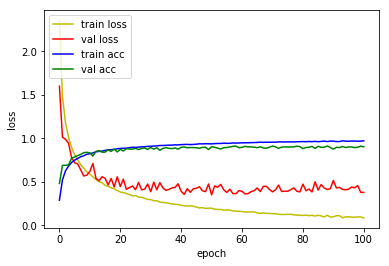

4815/4815 [==============================] - 8s 2ms/sample - loss: 0.4538 - acc: 0.8725
Loss: 0.4538032439267524 Accuracy: 0.8724818

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7025 - acc: 0.1864
Epoch 00001: val_loss improved from inf to 2.01884, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_DO_BN_7_conv_checkpoint/001-2.0188.hdf5
36805/36805 [==============================] - 190s 5ms/sample - loss: 2.7025 - acc: 0.1864 - val_loss: 2.0188 - val_acc: 0.3685
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9123 - acc: 0.3789
Epoch 00002: val_loss improved from 2.01884 to 1.36297, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_DO_BN_7_conv_checkpoint/002-1.3630.hdf5
36805/36805 [==============================] - 180s 5ms/sample - loss: 1.9122 - acc: 0.3789 - val_loss: 1.3630 - val_acc: 0.5998
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s 

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3692 - acc: 0.8883
Epoch 00025: val_loss did not improve from 0.32671
36805/36805 [==============================] - 180s 5ms/sample - loss: 0.3692 - acc: 0.8883 - val_loss: 0.3438 - val_acc: 0.9085
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3557 - acc: 0.8929
Epoch 00026: val_loss improved from 0.32671 to 0.30270, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_DO_BN_7_conv_checkpoint/026-0.3027.hdf5
36805/36805 [==============================] - 180s 5ms/sample - loss: 0.3557 - acc: 0.8929 - val_loss: 0.3027 - val_acc: 0.9133
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3366 - acc: 0.8961
Epoch 00027: val_loss did not improve from 0.30270
36805/36805 [==============================] - 180s 5ms/sample - loss: 0.3367 - acc: 0.8961 - val_loss: 0.3076 - val_acc: 0.9150
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s 

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1961 - acc: 0.9376
Epoch 00053: val_loss did not improve from 0.24896
36805/36805 [==============================] - 180s 5ms/sample - loss: 0.1961 - acc: 0.9376 - val_loss: 0.2615 - val_acc: 0.9336
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1959 - acc: 0.9389
Epoch 00054: val_loss did not improve from 0.24896
36805/36805 [==============================] - 180s 5ms/sample - loss: 0.1960 - acc: 0.9388 - val_loss: 0.2684 - val_acc: 0.9334
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1931 - acc: 0.9391
Epoch 00055: val_loss did not improve from 0.24896
36805/36805 [==============================] - 180s 5ms/sample - loss: 0.1930 - acc: 0.9391 - val_loss: 0.2567 - val_acc: 0.9369
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1844 - acc: 0.9418
Epoch 00056: val_loss did not improve from 0.24896
36805/36805 [========

36800/36805 [============================>.] - ETA: 0s - loss: 0.1207 - acc: 0.9622
Epoch 00082: val_loss did not improve from 0.22959
36805/36805 [==============================] - 180s 5ms/sample - loss: 0.1207 - acc: 0.9622 - val_loss: 0.2598 - val_acc: 0.9369
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1206 - acc: 0.9615
Epoch 00083: val_loss did not improve from 0.22959
36805/36805 [==============================] - 180s 5ms/sample - loss: 0.1207 - acc: 0.9615 - val_loss: 0.2783 - val_acc: 0.9350
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1172 - acc: 0.9628
Epoch 00084: val_loss did not improve from 0.22959
36805/36805 [==============================] - 180s 5ms/sample - loss: 0.1173 - acc: 0.9627 - val_loss: 0.2670 - val_acc: 0.9292
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1246 - acc: 0.9604
Epoch 00085: val_loss did not improve from 0.22959
36805/36805 [=====================

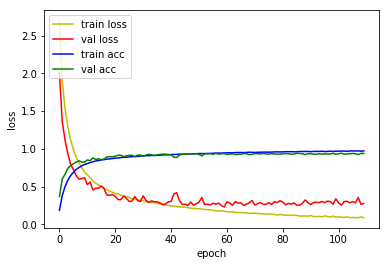

4815/4815 [==============================] - 8s 2ms/sample - loss: 0.2935 - acc: 0.9161
Loss: 0.2935313658117629 Accuracy: 0.91609555

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.8310 - acc: 0.1666
Epoch 00001: val_loss improved from inf to 2.15548, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_DO_BN_8_conv_checkpoint/001-2.1555.hdf5
36805/36805 [==============================] - 195s 5ms/sample - loss: 2.8309 - acc: 0.1666 - val_loss: 2.1555 - val_acc: 0.3529
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0868 - acc: 0.3300
Epoch 00002: val_loss improved from 2.15548 to 1.45581, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_DO_BN_8_conv_checkpoint/002-1.4558.hdf5
36805/36805 [==============================] - 181s 5ms/sample - loss: 2.0868 - acc: 0.3300 - val_loss: 1.4558 - val_acc: 0.5604
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3034 - acc: 0.9080
Epoch 00024: val_loss improved from 0.22776 to 0.22020, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_DO_BN_8_conv_checkpoint/024-0.2202.hdf5
36805/36805 [==============================] - 182s 5ms/sample - loss: 0.3034 - acc: 0.9079 - val_loss: 0.2202 - val_acc: 0.9378
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2867 - acc: 0.9135
Epoch 00025: val_loss improved from 0.22020 to 0.20848, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_DO_BN_8_conv_checkpoint/025-0.2085.hdf5
36805/36805 [==============================] - 182s 5ms/sample - loss: 0.2867 - acc: 0.9135 - val_loss: 0.2085 - val_acc: 0.9427
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2780 - acc: 0.9170
Epoch 00026: val_loss did not improve from 0.20848
36805/36805 [==============================] - 181s 5ms/sample - loss: 0.2780 - acc: 0.9169 - va

Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1551 - acc: 0.9504
Epoch 00051: val_loss did not improve from 0.16595
36805/36805 [==============================] - 181s 5ms/sample - loss: 0.1551 - acc: 0.9504 - val_loss: 0.2141 - val_acc: 0.9415
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1440 - acc: 0.9549
Epoch 00052: val_loss did not improve from 0.16595
36805/36805 [==============================] - 181s 5ms/sample - loss: 0.1440 - acc: 0.9549 - val_loss: 0.2000 - val_acc: 0.9462
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1406 - acc: 0.9553
Epoch 00053: val_loss did not improve from 0.16595
36805/36805 [==============================] - 181s 5ms/sample - loss: 0.1407 - acc: 0.9553 - val_loss: 0.1888 - val_acc: 0.9460
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1466 - acc: 0.9542
Epoch 00054: val_loss did not improve from 0.16595
36805/36805 [========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0838 - acc: 0.9739
Epoch 00080: val_loss did not improve from 0.16354
36805/36805 [==============================] - 181s 5ms/sample - loss: 0.0838 - acc: 0.9739 - val_loss: 0.1855 - val_acc: 0.9515
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0813 - acc: 0.9745
Epoch 00081: val_loss did not improve from 0.16354
36805/36805 [==============================] - 181s 5ms/sample - loss: 0.0817 - acc: 0.9744 - val_loss: 0.2264 - val_acc: 0.9425
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1020 - acc: 0.9663
Epoch 00082: val_loss did not improve from 0.16354
36805/36805 [==============================] - 181s 5ms/sample - loss: 0.1022 - acc: 0.9663 - val_loss: 0.1750 - val_acc: 0.9532
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0827 - acc: 0.9743
Epoch 00083: val_loss did not improve from 0.16354
36805/36805 [=====================

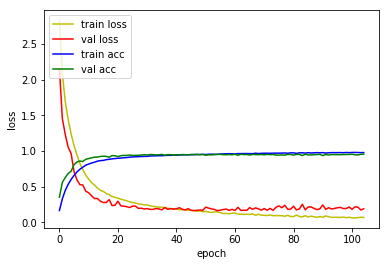

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.2099 - acc: 0.9373
Loss: 0.20994856844067203 Accuracy: 0.93727934

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.8115 - acc: 0.1828
Epoch 00001: val_loss improved from inf to 2.17029, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_DO_BN_9_conv_checkpoint/001-2.1703.hdf5
36805/36805 [==============================] - 200s 5ms/sample - loss: 2.8113 - acc: 0.1829 - val_loss: 2.1703 - val_acc: 0.3692
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9617 - acc: 0.3732
Epoch 00002: val_loss improved from 2.17029 to 1.34460, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_DO_BN_9_conv_checkpoint/002-1.3446.hdf5
36805/36805 [==============================] - 181s 5ms/sample - loss: 1.9616 - acc: 0.3732 - val_loss: 1.3446 - val_acc: 0.6287
Epoch 3/500
36800/36805 [============================>.] - ETA: 0

36800/36805 [============================>.] - ETA: 0s - loss: 0.3225 - acc: 0.9042
Epoch 00023: val_loss improved from 0.21427 to 0.20773, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_DO_BN_9_conv_checkpoint/023-0.2077.hdf5
36805/36805 [==============================] - 181s 5ms/sample - loss: 0.3225 - acc: 0.9041 - val_loss: 0.2077 - val_acc: 0.9446
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3113 - acc: 0.9064
Epoch 00024: val_loss improved from 0.20773 to 0.19987, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_DO_BN_9_conv_checkpoint/024-0.1999.hdf5
36805/36805 [==============================] - 181s 5ms/sample - loss: 0.3112 - acc: 0.9064 - val_loss: 0.1999 - val_acc: 0.9467
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3009 - acc: 0.9095
Epoch 00025: val_loss improved from 0.19987 to 0.18904, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_DO_BN_9_conv_checkpoint/025-0.1890.hdf5
36805/36

Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1452 - acc: 0.9555
Epoch 00050: val_loss improved from 0.16209 to 0.15471, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_DO_BN_9_conv_checkpoint/050-0.1547.hdf5
36805/36805 [==============================] - 182s 5ms/sample - loss: 0.1456 - acc: 0.9554 - val_loss: 0.1547 - val_acc: 0.9574
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1563 - acc: 0.9521
Epoch 00051: val_loss did not improve from 0.15471
36805/36805 [==============================] - 181s 5ms/sample - loss: 0.1563 - acc: 0.9521 - val_loss: 0.1717 - val_acc: 0.9532
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1456 - acc: 0.9546
Epoch 00052: val_loss did not improve from 0.15471
36805/36805 [==============================] - 181s 5ms/sample - loss: 0.1456 - acc: 0.9546 - val_loss: 0.1748 - val_acc: 0.9567
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s 

Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0898 - acc: 0.9721
Epoch 00078: val_loss did not improve from 0.15126
36805/36805 [==============================] - 182s 5ms/sample - loss: 0.0899 - acc: 0.9720 - val_loss: 0.1681 - val_acc: 0.9585
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1051 - acc: 0.9671
Epoch 00079: val_loss improved from 0.15126 to 0.15029, saving model to model/checkpoint/1D_CNN_custom_4_ch_128_DO_BN_9_conv_checkpoint/079-0.1503.hdf5
36805/36805 [==============================] - 182s 5ms/sample - loss: 0.1051 - acc: 0.9671 - val_loss: 0.1503 - val_acc: 0.9604
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0930 - acc: 0.9704
Epoch 00080: val_loss did not improve from 0.15029
36805/36805 [==============================] - 182s 5ms/sample - loss: 0.0930 - acc: 0.9704 - val_loss: 0.1574 - val_acc: 0.9623
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s 

36800/36805 [============================>.] - ETA: 0s - loss: 0.0623 - acc: 0.9801
Epoch 00107: val_loss did not improve from 0.15029
36805/36805 [==============================] - 182s 5ms/sample - loss: 0.0624 - acc: 0.9801 - val_loss: 0.1689 - val_acc: 0.9585
Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0719 - acc: 0.9780
Epoch 00108: val_loss did not improve from 0.15029
36805/36805 [==============================] - 182s 5ms/sample - loss: 0.0721 - acc: 0.9780 - val_loss: 0.2771 - val_acc: 0.9362
Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0767 - acc: 0.9763
Epoch 00109: val_loss did not improve from 0.15029
36805/36805 [==============================] - 182s 5ms/sample - loss: 0.0772 - acc: 0.9763 - val_loss: 0.2050 - val_acc: 0.9529
Epoch 110/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0737 - acc: 0.9766
Epoch 00110: val_loss did not improve from 0.15029
36805/36805 [==================

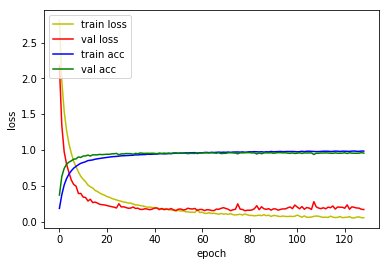

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.2100 - acc: 0.9408
Loss: 0.21001893762278595 Accuracy: 0.94080997



In [10]:
for i in range(4, 10):
    base = '1D_CNN_custom_4_ch_128_DO_BN'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_DO_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_4_ch_128_DO_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(4, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_4_ch_128_DO_BN_4_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1_45 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
batch_normalization_v1_46 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_46 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
max_pooling1d_36 (MaxPooling (Non

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.4538 - acc: 0.8725
Loss: 0.4538032439267524 Accuracy: 0.8724818

1D_CNN_custom_4_ch_128_DO_BN_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_60 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1_60 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_60 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
batch_normalization_v1_61 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_61 (Activation)   (No

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.2099 - acc: 0.9373
Loss: 0.20994856844067203 Accuracy: 0.93727934

1D_CNN_custom_4_ch_128_DO_BN_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_75 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1_75 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_75 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_76 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
batch_normalization_v1_76 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_76 (Activation)   (

In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(4, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_4_ch_128_DO_BN_4_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1_45 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
batch_normalization_v1_46 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_46 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
max_pooling1d_36 (MaxPooling (Non

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.5076 - acc: 0.8685
Loss: 0.5076343005969889 Accuracy: 0.8685358

1D_CNN_custom_4_ch_128_DO_BN_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_60 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1_60 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_60 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
batch_normalization_v1_61 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_61 (Activation)   (No

4815/4815 [==============================] - 10s 2ms/sample - loss: 0.2479 - acc: 0.9371
Loss: 0.24785564507465124 Accuracy: 0.9370716

1D_CNN_custom_4_ch_128_DO_BN_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_75 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1_75 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_75 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_76 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
batch_normalization_v1_76 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_76 (Activation)   (